# 參數設定 (使用訊號分解)

In [1]:
import os

labels = ['GroupCount']
model_type = 3 # 使用模型
predicteds = [5] # 預測類別 
batch_size = 14  # 批次大小

# labels = ['GroupCount']
# model_type = 1 # 使用模型
# predicteds = [1] # 預測類別 
# batch_size = 14  # 批次大小


# ==== 底下的參數基本上都不要亂動 ====
past_day = 14  # 過去天數，用於訓練資料中的歷史資料長度
future_day = 1

train_split_rate = 0.8  # 訓練集佔整體資料集的比例
val_split_rate = 0.1 # 驗證集占整體資料集的比例

is_emd = False # 是否使用 EMD，False 則使用 EEMD
 
model_dir = 'DecompEEMD/_Model'

# !pip install EMD-signal
# https://github.com/laszukdawid/PyEMD/tree/master

# 定義類別

In [2]:
import joblib

# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import LstmLib 
importlib.reload(LstmLib)   

from LstmLib import * 
lstm = LstmLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
x_scaler_file_name, y_scaler_file_name, model_file_name, result_file_name = \
    lstm.reset_data(model_dir, labels, model_type, predicteds, batch_size)

x_scaler_file_name: DecompEEMD/_Model/GroupCount_mt3_data5_batch14.x_scaler.pkl
y_scaler_file_name: DecompEEMD/_Model/GroupCount_mt3_data5_batch14.y_scaler.pkl
model_file_name: DecompEEMD/_Model/GroupCount_mt3_data5_batch14.model.keras
result_file_name: DecompEEMD/_Model/GroupCount_mt3_data5_batch14.result.json


# 載入數據

In [4]:
df_source = lstm.load_data(predicteds)

print(len(df_source))
df_source.head()

# 載入數據
395


,RequestTime,Predicted,SendBytes,ReceiveBytes,TimeTaken,UrlType1,UrlType2,UrlType3,Method_GET,Method_POST,Method_PUT,Method_DELETE,Method_HEAD,Method_OPTIONS,Method_PATCH,GroupCount
0,2023-04-02,[5],156009964,1063367,873569,9,2531,64,2604,0,0,0,0,0,0,2604
1,2023-04-03,[5],266983699,1670644,1289435,33,3928,75,4034,2,0,0,0,0,0,4036
2,2023-04-04,[5],198064713,1377806,881103,8,3552,72,3630,2,0,0,0,0,0,3632
3,2023-04-05,[5],275355693,1804631,1005218,8,4270,101,4378,1,0,0,0,0,0,4379
4,2023-04-06,[5],226168175,2059599,1254506,40,5491,82,5612,0,0,0,1,0,0,5613


# 訊號分解

# 訊號分解
EEMD


IMFs shape : (8, 395)
eIMFs shape : (8, 395)
residue shape : (395,)


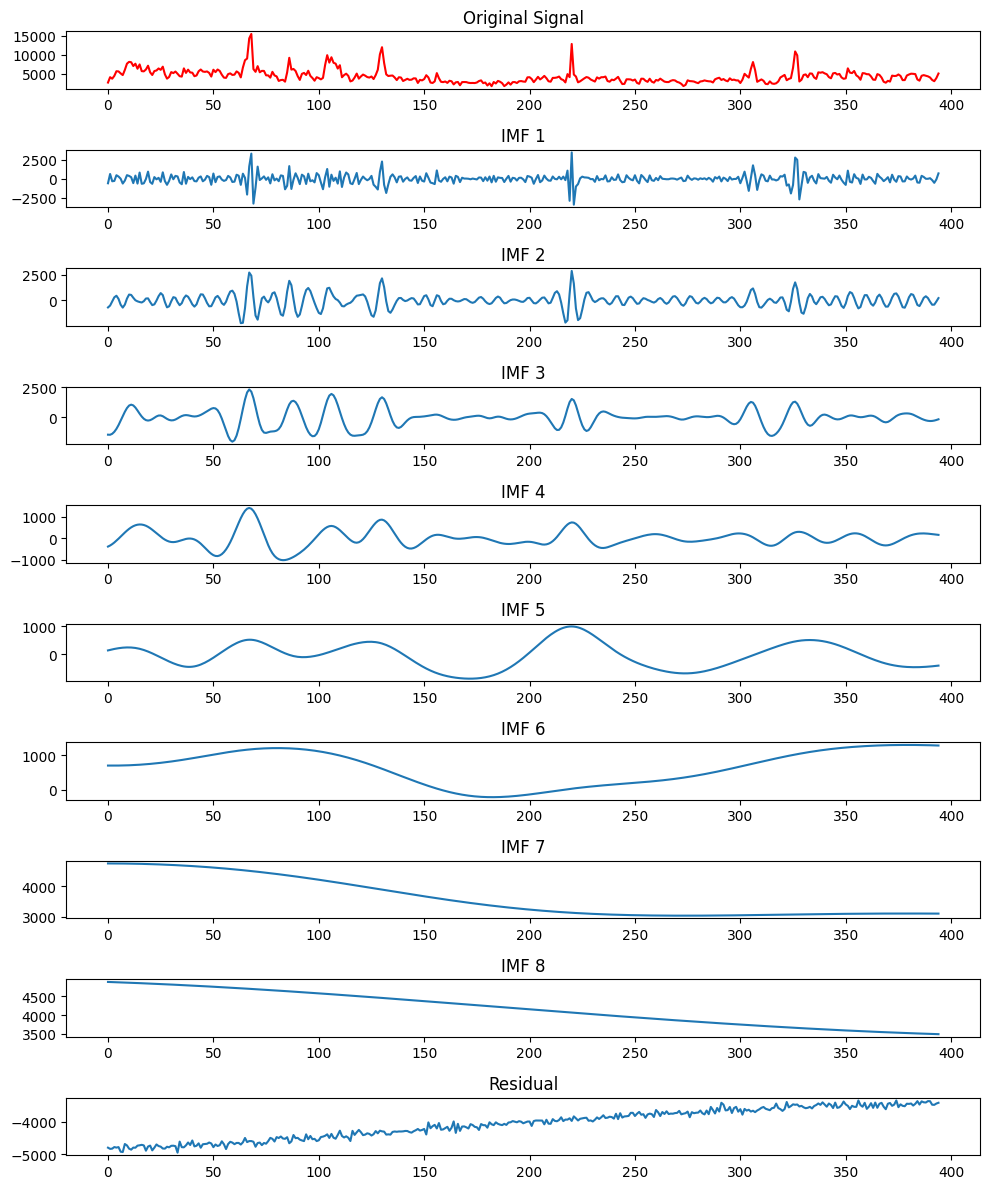

In [5]:
data_source = df_source[labels].values
eIMFs, residue, imfs = lstm.decomposition(data_source, is_emd = is_emd)

# 刪除訊號分解後的訓練資料

In [6]:
def print_step(index):
    print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
    # 最後一個是殘差
    if index == len(imfs):
        print(f'\x1b[31m殘差\x1b[0m')
    else:
        print(f'\x1b[31m第 {index} 個 IMF\x1b[0m')
        print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
   

for i in range(len(imfs)):
    print_step(i + 1)

    lstm.del_file(x_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(y_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(model_file_name.replace('.keras', f'.{i + 1}.keras'))

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
----------------------------------------------------------------

# 最小最大正規化

In [7]:
x_norms = []
y_norms = []
x_scalers = []
y_scalers = []

for i in range(1, len(imfs) + 1):
    print_step(i) 
    x_norm, y_norm, x_scaler, y_scaler = \
        lstm.normalize_by_decomposition(imfs[i - 1]); 

    x_norms.append(x_norm)
    y_norms.append(y_norm)
    x_scalers.append(x_scaler)
    y_scalers.append(y_scaler)

    joblib.dump(x_scaler, x_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    joblib.dump(y_scaler, y_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    print('儲存最小最大縮放參數')
  

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 5 個 IMF
---------------------------------

# 切割訓練、驗證和測試資料集

In [8]:
x_trains = []
y_trains = []

x_vals = []
y_vals = []

x_tests = []
y_tests = []

for i in range(len(x_norms)):
    print_step(i + 1)
    
    x_train, y_train, x_val, y_val, x_test, y_test = \
        lstm.train_val_test_split(
            x_norms[i],  
            train_split_rate = train_split_rate,
            val_split_rate = val_split_rate
        )

    x_trains.append(x_train)
    y_trains.append(y_train)

    x_vals.append(x_val)
    y_vals.append(y_val)

    x_tests.append(x_test)
    y_tests.append(y_test)
    

print('\n\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已切割\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_trains len : {len(x_trains)}')
print(f'y_trains len : {len(y_trains)}')
print(f'x_vals len : {len(x_vals)}')
print(f'y_vals len : {len(y_vals)}')
print(f'x_tests len : {len(x_tests)}')
print(f'y_tests len : {len(y_tests)}')


------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 4 個 IMF

# 將資料轉成 LSTM 模型所需資料格式(三維)

In [9]:
x_lstm_trains = []
y_lstm_trains = []

x_lstm_vals = []
y_lstm_vals = []

x_lstm_tests = []
y_lstm_tests = []

for i in range(len(x_trains)):
    print_step(i + 1)
    
    # 訓練集
    x_lstm_train, y_lstm_train, _ = \
        lstm.reshape_data_for_lstm(
            x_trains[i], y_trains[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        ) 
    print('====== Train DataSet ======')
    print('訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) :', x_lstm_train.shape)
    print('訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) :', y_lstm_train.shape)

    # 驗證集
    x_lstm_val, y_lstm_val, _ = \
        lstm.reshape_data_for_lstm(
            x_vals[i], y_vals[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Val DataSet ======')
    print('驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) :', x_lstm_val.shape)
    print('驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) :', y_lstm_val.shape)

    # 測試集
    x_lstm_test, y_lstm_test, _ = \
        lstm.reshape_data_for_lstm(
            x_tests[i], y_tests[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Test DataSet ======')
    print('測試集 : x_lstm_test (筆數, 天數, 特徵數) :', x_lstm_test.shape)
    print('測試集 : y_lstm_test (筆數, 天數, 標籤數) :', y_lstm_test.shape)
     
    x_lstm_trains.append(x_lstm_train)
    y_lstm_trains.append(y_lstm_train)

    x_lstm_vals.append(x_lstm_val)
    y_lstm_vals.append(y_lstm_val)

    x_lstm_tests.append(x_lstm_test)
    y_lstm_tests.append(y_lstm_test)

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已轉換\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_lstm_trains len : {len(x_lstm_trains)}')
print(f'y_lstm_trains len : {len(y_lstm_trains)}')
print(f'x_lstm_vals len : {len(x_lstm_vals)}')
print(f'y_lstm_vals len : {len(y_lstm_vals)}')
print(f'x_lstm_tests len : {len(x_lstm_tests)}')
print(f'y_lstm_tests len : {len(y_lstm_tests)}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (301, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) : (24, 14, 1)
驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) : (24, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Test DataSet ======
測試集 : x_lstm_test (筆數, 天數, 特徵數) : (25, 14, 1)
測試集 : y_lstm_test (筆數, 天數, 標籤數) : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (301, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗

# 定義 Model

In [10]:
models = []

for i in range(len(x_trains)):
    print_step(i + 1)    
    
    # 定義 Model
    model = lstm.build_model(
        model_type = model_type,
        time_step = past_day,
        n_predictions = future_day
    )
    
    models.append(model)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 定義 Model：3
CNN-LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,172 (317.08 KB)

 Trainable params: 81,172 (317.08 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 定義 Model：3
CNN-LSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,172 (317.08 KB)

 Trainable params: 81,172 (317.08 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 定義 Model：3
CNN-LSTM


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,172 (317.08 KB)

 Trainable params: 81,172 (317.08 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 定義 Model：3
CNN-LSTM


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,172 (317.08 KB)

 Trainable params: 81,172 (317.08 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 定義 Model：3
CNN-LSTM


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,172 (317.08 KB)

 Trainable params: 81,172 (317.08 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 定義 Model：3
CNN-LSTM


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,172 (317.08 KB)

 Trainable params: 81,172 (317.08 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 定義 Model：3
CNN-LSTM


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,172 (317.08 KB)

 Trainable params: 81,172 (317.08 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 定義 Model：3
CNN-LSTM


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,172 (317.08 KB)

 Trainable params: 81,172 (317.08 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
殘差
# 定義 Model：3
CNN-LSTM


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 13, 7)               │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 6, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 100)                 │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,172 (317.08 KB)

 Trainable params: 81,172 (317.08 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練

In [11]:
train_historys = []

for i in range(len(models)):
    print_step(i + 1) 
        
    train_history = lstm.model_fit(
        model = models[i],
        batch_size = batch_size,
        x_train = x_lstm_trains[i],
        y_train = y_lstm_trains[i],
        x_val = x_lstm_vals[i],
        y_val = y_lstm_vals[i],
    ) 
    
    train_historys.append(train_history) 

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
殘差
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


# 儲存模型

In [12]:
for i in range(len(models)):
    print_step(i + 1)   

    file_name = f'{model_file_name.replace(".keras", f".{i + 1}.keras")}'
    models[i].save(file_name)
    print(f'儲存模型到 {file_name}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt3_data5_batch14.model.1.keras
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt3_data5_batch14.model.2.keras
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt3_data5_batch14.model.3.keras
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt3_data5_batch14.model.4.keras
------------------------------------------------------------------------
第 5 個 IMF
-------------------------

# 預測

In [13]:
predict_trains = []
predict_vals = []
predict_tests = []

for i in range(len(models)):
    print_step(i + 1)    
  
    predict_train = lstm.predict(models[i], x_lstm_trains[i])
    print(f'預測 train.shape : {predict_train.shape}')

    predict_val = lstm.predict(models[i], x_lstm_vals[i])
    print(f'預測 val.shape : {predict_val.shape}')

    predict_test = lstm.predict(models[i], x_lstm_tests[i])
    print(f'預測 test.shape : {predict_test.shape}') 
    
    predict_trains.append(predict_train)
    predict_vals.append(predict_val)
    predict_tests.append(predict_test)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 預測
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
殘差
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)


# 回復預測資料值為原始數據的規模

In [14]:
predict_inverse_trains = []
predict_inverse_vals = []
predict_inverse_tests = []

actual_inverse_trains = []
actual_inverse_vals = []
actual_inverse_tests = []

actual_trains = []
actual_vals = []
actual_tests = []


for i in range(len(models)):
    print_step(i + 1)
    
    # 訓練
    predict_inverse_train, actual_inverse_train, predict_train, actual_train = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_trains[i],
            y_lstm_actual = y_lstm_trains[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_train.shape : {predict_inverse_train.shape}') 
    print(f'actual_inverse_train.shape : {actual_inverse_train.shape}')

    # 驗證
    predict_inverse_val, actual_inverse_val, predict_val, actual_val = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_vals[i],
            y_lstm_actual = y_lstm_vals[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_val.shape : {predict_inverse_val.shape}')
    print(f'actual_inverse_val.shape : {actual_inverse_val.shape}')
    
    # 測試
    predict_inverse_test, actual_inverse_test, predict_test, actual_test = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_tests[i],
            y_lstm_actual = y_lstm_tests[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_test.shape : {predict_inverse_test.shape}')
    print(f'actual_inverse_test.shape : {actual_inverse_test.shape}')

    predict_inverse_trains.append(predict_inverse_train)
    predict_inverse_vals.append(predict_inverse_val)
    predict_inverse_tests.append(predict_inverse_test)

    actual_inverse_trains.append(actual_inverse_train)
    actual_inverse_vals.append(actual_inverse_val)
    actual_inverse_tests.append(actual_inverse_test)

    actual_trains.append(actual_train)
    actual_vals.append(actual_val)
    actual_tests.append(actual_test)
    

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
-------------------------------------------------------

# 預測資料加總

In [15]:
# 根據原始數據進行切割
x_train_origin, y_train_origin , x_val_origin, y_val_origin, x_test_origin, y_test_origin = \
    lstm.train_val_test_split(data_source, train_split_rate, val_split_rate)

# 使用原始數據進行 LSTM 模型所需的格式資料轉換
# 主要是為了後面的驗證圖表
y_lstm_origin_train, y_lstm_origin_train, _ = lstm.reshape_data_for_lstm(
    x_train_origin, y_train_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_train = y_lstm_origin_train.reshape(
    y_lstm_origin_train.shape[0], 
    y_lstm_origin_train.shape[1]
)

print(f'x_lstm_origin_train.shape : {y_lstm_origin_train.shape}')
print(f'y_lstm_origin_train.shape : {y_lstm_origin_train.shape}')

x_lstm_origin_test, y_lstm_origin_test, _ = lstm.reshape_data_for_lstm(
    x_test_origin, y_test_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_test = y_lstm_origin_test.reshape(
    y_lstm_origin_test.shape[0], 
    y_lstm_origin_test.shape[1]
)

print(f'x_lstm_origin_test.shape : {x_lstm_origin_test.shape}')
print(f'y_lstm_origin_test.shape : {y_lstm_origin_test.shape}')

x_lstm_origin_val, y_lstm_origin_val, _ = lstm.reshape_data_for_lstm(
    x_val_origin, y_val_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_val = y_lstm_origin_val.reshape(
    y_lstm_origin_val.shape[0], 
    y_lstm_origin_val.shape[1]
)

print(f'x_lstm_origin_val.shape : {x_lstm_origin_val.shape}')
print(f'y_lstm_origin_val.shape : {y_lstm_origin_val.shape}')

# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_train.shape : (301, 1)
y_lstm_origin_train.shape : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_test.shape : (25, 14, 1)
y_lstm_origin_test.shape : (25, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_val.shape : (24, 14, 1)
y_lstm_origin_val.shape : (24, 1)


In [16]:
predict_inverse_train_sum = np.sum(predict_inverse_trains, axis=0)
actual_inverse_train_sum = np.sum(actual_inverse_trains, axis=0)

predict_inverse_val_sum = np.sum(predict_inverse_vals, axis=0)
actual_inverse_val_sum = np.sum(actual_inverse_vals, axis=0)

predict_inverse_test_sum = np.sum(predict_inverse_tests, axis=0)
actual_inverse_test_sum = np.sum(actual_inverse_tests, axis=0)

print('predict_inverse_train_sum', predict_inverse_train_sum.shape)
print('actual_inverse_train_sum', actual_inverse_train_sum.shape)

print('predict_inverse_val_sum', predict_inverse_val_sum.shape)
print('actual_inverse_val_sum', actual_inverse_val_sum.shape)

print('predict_inverse_test_sum', predict_inverse_test_sum.shape)
print('actual_inverse_test_sum', actual_inverse_test_sum.shape)

predict_inverse_train_sum (301, 1)
actual_inverse_train_sum (301, 1)
predict_inverse_val_sum (24, 1)
actual_inverse_val_sum (24, 1)
predict_inverse_test_sum (25, 1)
actual_inverse_test_sum (25, 1)


# 查看訓練 & 驗證 & 測試集評估數據

In [17]:
for i in range(len(models)):
    print_step(i + 1)
    print('\033[93m# 查看訓練 & 驗證 & 測試集評估數據\x1b[0m')

    print('====== Train Evaluate ======')
    lstm.evaluation(models[i], x_lstm_trains[i], y_lstm_trains[i])
    print('--- 訓練值比較 --- ')
    lstm.score(actual_trains[i], predict_trains[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_trains[i], predict_inverse_trains[i])
    print('')

    print('====== Val Evaluate ======')
    lstm.evaluation(models[i], x_lstm_vals[i], y_lstm_vals[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_vals[i], predict_vals[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_vals[i], predict_inverse_vals[i])
    print('')

    print('====== Test Evaluate ======')
    lstm.evaluation(models[i], x_lstm_tests[i], y_lstm_tests[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_tests[i], predict_tests[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_tests[i], predict_inverse_tests[i])
    print('')
    
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Train Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_train, mape_train = lstm.score(y_lstm_origin_train, predict_inverse_train_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Val Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_val, mape_val = lstm.score(y_lstm_origin_val, predict_inverse_val_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Test Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_test, mape_test = lstm.score(y_lstm_origin_test, predict_inverse_test_sum)
print('')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mean_absolute_percentage_error: 12.6251

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0098 - mean_absolute_percentage_error: 31.8320

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0108 - mean_absolute_percentage_error: 833846.0625


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.06354，MAPE:7423078661817.63，MSE:0.00978，RMSE:0.09891，R square:0.01095
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:439.49163，MAPE:1.12978，MSE:468041.26458，RMSE:684.13541，R square:0.01095

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mean_absolute_percentage_error: 11.7597

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mean_absolute_percentage_error: 11.7597


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.05838，MAPE:0.1176，MSE:0.00522，RMSE:0.07223，R square:-0.0473
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:403.83054，MAPE:0.94099，MSE:249634.2504，RMSE:499.63412，R square:-0.0473

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - mean_absolute_percentage_error: 8.4458

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mean_absolute_percentage_error: 8.4458


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.04135，MAPE:0.08446，MSE:0.00252，RMSE:0.05024，R square:0.00258
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:285.98882，MAPE:0.92543，MSE:120740.59799，RMSE:347.47748，R square:0.00258

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mean_absolute_percentage_error: 11.0706

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0058 - mean_absolute_percentage_error: 825865.8750


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.05517，MAPE:2130390284594.4617，MSE:0.00525，RMSE:0.07244，R square:0.70692
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:277.63125，MAPE:2.821，MSE:132905.83635，RMSE:364.56253，R square:0.70692

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mean_absolute_percentage_error: 9.9919

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mean_absolute_percentage_error: 9.9919


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.04382，MAPE:0.09992，MSE:0.00309，RMSE:0.05556，R square:0.56206
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:220.53367，MAPE:1.53437，MSE:78164.40934，RMSE:279.57899，R square:0.56206

====== Test Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_absolute_percentage_error: 11.2548

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mean_absolute_percentage_error: 11.2548


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.0503，MAPE:0.11255，MSE:0.00319，RMSE:0.0565，R square:0.5475
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:253.10744，MAPE:1.01574，MSE:80855.06734，RMSE:284.35025，R square:0.5475

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mean_absolute_percentage_error: 6.2893

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0016 - mean_absolute_percentage_error: 198726.5000


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.02797，MAPE:512624379108.02325，MSE:0.00134，RMSE:0.03667，R square:0.95408
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:120.34062，MAPE:0.86431，MSE:24893.88155，RMSE:157.77795，R square:0.95408

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mean_absolute_percentage_error: 6.8308

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mean_absolute_percentage_error: 6.8308


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.02697，MAPE:0.06831，MSE:0.0014，RMSE:0.03737，R square:0.65155
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:116.03818，MAPE:0.65724，MSE:25850.52488，RMSE:160.78098，R square:0.65155

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4612e-04 - mean_absolute_percentage_error: 3.2170

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4612e-04 - mean_absolute_percentage_error: 3.2170


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.01523，MAPE:0.03217，MSE:0.00035，RMSE:0.0186，R square:0.8874
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:65.53506，MAPE:0.35026，MSE:6407.63909，RMSE:80.04773，R square:0.8874

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0789e-04 - mean_absolute_percentage_error: 4.7914

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 6.2162e-04 - mean_absolute_percentage_error: 240824.8438


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.01763，MAPE:822668389815.0424，MSE:0.00049，RMSE:0.02213，R square:0.98398
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:42.99062，MAPE:0.76876，MSE:2909.72178，RMSE:53.94184，R square:0.98398

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3577e-04 - mean_absolute_percentage_error: 2.9465

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3577e-04 - mean_absolute_percentage_error: 2.9465


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.01218，MAPE:0.02946，MSE:0.00024，RMSE:0.01535，R square:0.9417
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:29.69777，MAPE:0.48182，MSE:1401.25635，RMSE:37.43336，R square:0.9417

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6568e-05 - mean_absolute_percentage_error: 1.6904

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6568e-05 - mean_absolute_percentage_error: 1.6904


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00727，MAPE:0.0169，MSE:7e-05，RMSE:0.00816，R square:0.98877
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:17.72273，MAPE:0.19291，MSE:395.63993，RMSE:19.8907，R square:0.98877

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9635e-04 - mean_absolute_percentage_error: 7.6580

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 4.6464e-04 - mean_absolute_percentage_error: 22563.5898


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.0134，MAPE:123872233329.4085，MSE:0.0003，RMSE:0.01728，R square:0.99543
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:25.21342，MAPE:6.20685，MSE:1056.97563，RMSE:32.51116，R square:0.99543

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9023e-05 - mean_absolute_percentage_error: 1.1150

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9023e-05 - mean_absolute_percentage_error: 1.1150


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00766，MAPE:0.01115，MSE:8e-05，RMSE:0.00889，R square:0.98426
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:14.41214，MAPE:0.04284，MSE:279.72926，RMSE:16.72511，R square:0.98426

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7535e-05 - mean_absolute_percentage_error: 2.6603

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7535e-05 - mean_absolute_percentage_error: 2.6603


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00629，MAPE:0.0266，MSE:5e-05，RMSE:0.00689，R square:0.81905
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:11.84069，MAPE:0.02702，MSE:168.26804，RMSE:12.97182，R square:0.81905

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8443e-05 - mean_absolute_percentage_error: 1.2807

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 6.2334e-05 - mean_absolute_percentage_error: 1.0639

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 3.4885e-05 - mean_absolute_percentage_error: 2342.7991


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00366，MAPE:16231162209.89148，MSE:2e-05，RMSE:0.00465，R square:0.99977
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:5.50035，MAPE:0.08765，MSE:48.77995，RMSE:6.98426，R square:0.99977

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9613e-05 - mean_absolute_percentage_error: 0.3865

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9613e-05 - mean_absolute_percentage_error: 0.3865


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00363，MAPE:0.00387，MSE:2e-05，RMSE:0.00443，R square:0.98276
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:5.44986，MAPE:0.00455，MSE:44.32457，RMSE:6.65767，R square:0.98276

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5479e-04 - mean_absolute_percentage_error: 1.5981

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5479e-04 - mean_absolute_percentage_error: 1.5981


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.01593，MAPE:0.01598，MSE:0.00025，RMSE:0.01596，R square:-25.21636
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:23.94978，MAPE:0.01862，MSE:575.81337，RMSE:23.99611，R square:-25.21638

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0480e-05 - mean_absolute_percentage_error: 0.3742

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 9.5701e-06 - mean_absolute_percentage_error: 2631.5596


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00202，MAPE:41307470568.90753，MSE:1e-05，RMSE:0.00278，R square:0.99994
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:3.46121，MAPE:0.00093，MSE:22.7589，RMSE:4.77063，R square:0.99994

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8948e-04 - mean_absolute_percentage_error: 44.0303

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8948e-04 - mean_absolute_percentage_error: 44.0303


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.01376，MAPE:0.4403，MSE:0.00019，RMSE:0.01377，R square:-15.73453
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:23.60025，MAPE:0.00765，MSE:557.35462，RMSE:23.60836，R square:-15.73459

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6310e-04 - mean_absolute_percentage_error: 31.3781

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6310e-04 - mean_absolute_percentage_error: 31.3781


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.01276，MAPE:0.31378，MSE:0.00016，RMSE:0.01277，R square:-725.54553
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:21.87989，MAPE:0.00706，MSE:479.76009，RMSE:21.90343，R square:-725.54634

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7253e-07 - mean_absolute_percentage_error: 0.0804

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 1.7569e-06 - mean_absolute_percentage_error: 0.1586


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00095，MAPE:0.00173，MSE:0.0，RMSE:0.00115，R square:0.99998
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:1.33413，MAPE:0.0003，MSE:2.57462，RMSE:1.60456，R square:0.99998

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.4847e-07 - mean_absolute_percentage_error: 1.0894

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4847e-07 - mean_absolute_percentage_error: 1.0894


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00092，MAPE:0.01089，MSE:0.0，RMSE:0.00092，R square:0.99575
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:1.28982，MAPE:0.00036，MSE:1.66572，RMSE:1.29063，R square:0.99575

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1067e-06 - mean_absolute_percentage_error: 187897.5000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1067e-06 - mean_absolute_percentage_error: 187897.5000


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00083，MAPE:846121643540.6874，MSE:0.0，RMSE:0.00145，R square:0.98112
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:1.16774，MAPE:0.00033，MSE:4.13604，RMSE:2.03372，R square:0.98112

------------------------------------------------------------------------
殘差
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_absolute_percentage_error: 3355191.5000

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.0021 - mean_absolute_percentage_error: 927747.9375


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.03444，MAPE:1606411186026.4263，MSE:0.00204，RMSE:0.04515，R square:0.96378
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:55.73312，MAPE:0.0134，MSE:5336.64282，RMSE:73.05233，R square:0.96378

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_absolute_percentage_error: 4.1810

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_absolute_percentage_error: 4.1810


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.03728，MAPE:0.04181，MSE:0.00189，RMSE:0.0435，R square:-0.25994
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:60.32487，MAPE:0.01722，MSE:4955.17505，RMSE:70.393，R square:-0.25995

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - mean_absolute_percentage_error: 2.8300

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - mean_absolute_percentage_error: 2.8300


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.02677，MAPE:0.0283，MSE:0.00105，RMSE:0.03241，R square:0.05175
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:43.31052，MAPE:0.01267，MSE:2750.60037，RMSE:52.44617，R square:0.05175

------------------------------------------------------------------------
合併後 Train Evaluate
------------------------------------------------------------------------
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:565.06821，MAPE:0.12891，MSE:725264.71359，RMSE:851.62475，R square:0.79101

------------------------------------------------------------------------
合併後 Val Evaluate
------------------------------------------------------------------------
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:555.52133，MAPE:0.11463，MSE:475178.06286，RMSE:689.33161，R square:0.07067

------------------------------------------------------------------------
合併後 Test Evaluate
------------------------------------------------------------------------

# 顯示預測圖表

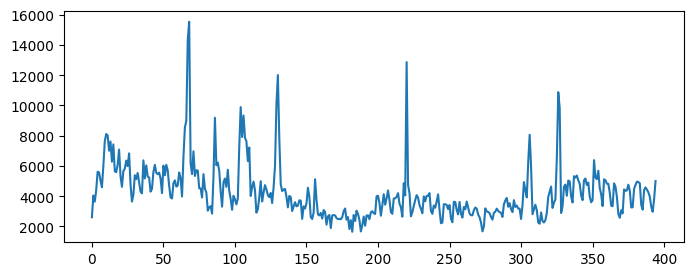

In [18]:
plt.figure(figsize=(8, 3))
plt.plot(data_source)
plt.show()

## 訓練集

原始資料 (316, 1)
[[2178]
 [2917]
 [2357]]
原始資料2 (301, 1)
[[2178]
 [2917]
 [2357]]
還原原始資料 (301, 1)
[[-3635.80515601]
 [-3573.80275079]]


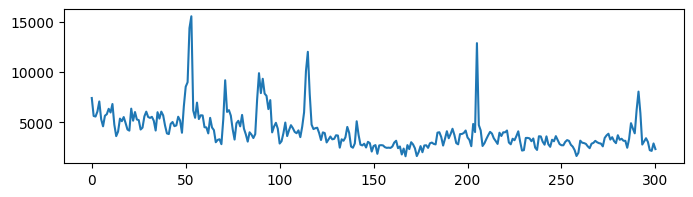

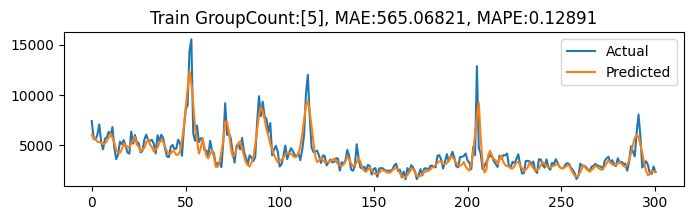

In [19]:
print('原始資料' , y_train_origin.shape)
print(y_train_origin[-3:])

print('原始資料2', y_lstm_origin_train.shape)
print(y_lstm_origin_train[-3:])

print('還原原始資料', actual_inverse_train.shape)
print(actual_inverse_train[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_train,
    predict = predict_inverse_train_sum,
    title = f'Train {labels[0]}:{predicteds}, MAE:{round(mae_train, 5)}, MAPE:{round(mape_train, 5)}'
)

## 驗證集

原始資料 (39, 1)
[[5237]
 [5122]
 [5679]]
原始資料2 (24, 1)
[[5237]
 [5122]
 [5679]]
還原原始資料 (24, 1)
[[-3500.49802582]
 [-3531.38902282]]


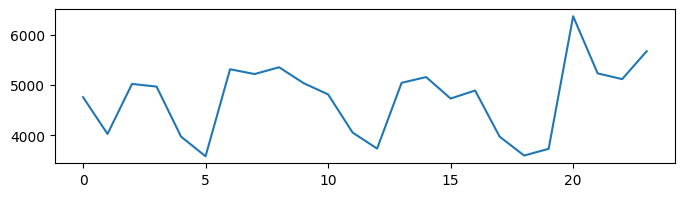

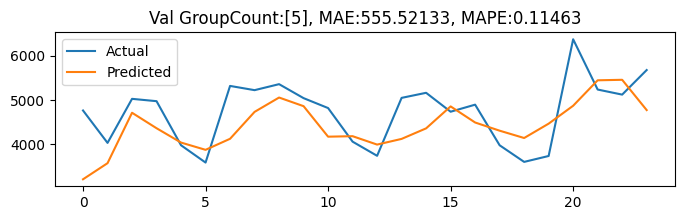

In [20]:
print('原始資料' , y_val_origin.shape)
print(y_val_origin[-3:])

print('原始資料2', y_lstm_origin_val.shape)
print(y_lstm_origin_val[-3:])

print('還原原始資料', actual_inverse_val.shape)
print(actual_inverse_val[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_val,
    predict = predict_inverse_val_sum,
    title = f'Val {labels[0]}:{predicteds}, MAE:{round(mae_val, 5)}, MAPE:{round(mape_val, 5)}'
)

## 測試集

原始資料 (40, 1)
[[2964]
 [3799]
 [5001]]
原始資料2 (25, 1)
[[2964]
 [3799]
 [5001]]
還原原始資料 (25, 1)
[[-3430.3067866 ]
 [-3406.33800268]]
Test GroupCount:[5], BatchSize:14, MAE:449.1519, MAPE:0.10581


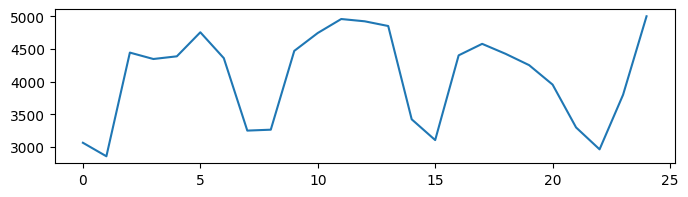

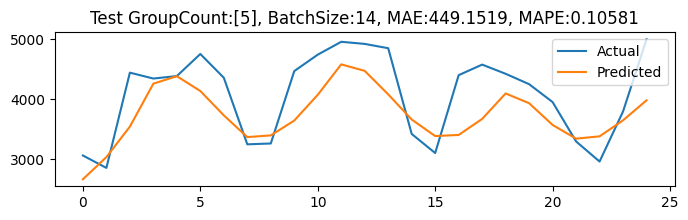

In [21]:
print('原始資料' , y_test_origin.shape)
print(y_test_origin[-3:])

print('原始資料2', y_lstm_origin_test.shape)
print(y_lstm_origin_test[-3:])

print('還原原始資料', actual_inverse_test.shape)
print(actual_inverse_test[-2:]) 

title = f'Test {labels[0]}:{predicteds}, BatchSize:{batch_size}, MAE:{round(mae_test, 5)}, MAPE:{round(mape_test, 5)}'
print(title)

lstm.show_predict_chart(
    actual = y_lstm_origin_test,
    predict = predict_inverse_test_sum,
    title = title
)

# 儲存結果

In [22]:
lstm.save_json_file(
    result_file_name, model_dir, labels, model_type, predicteds, 
    batch_size, mae_train, mape_train, mae_test, mape_test,
    imfs = len(imfs)
)

{'type': 'DecompEEMD', 'labels': ['GroupCount'], 'model_type': 3, 'predicteds': [5], 'batch_size': 14, 'train_mae': 565.06821, 'train_mape': 0.12891, 'test_mae': 449.1519, 'test_mape': 0.10581, 'kfold': None, 'imfs': 9}
儲存評估結果到 DecompEEMD/_Model/GroupCount_mt3_data5_batch14.result.json
